# 1. Tiền xử lý

## 1.1. Thêm thư viện

In [ ]:
#libraries
import numpy as np 
import pandas as pd 
import os
import json
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from PIL import Image
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import gc
from catboost import CatBoostClassifier
from tqdm import tqdm_notebook
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import random
import warnings
warnings.filterwarnings("ignore")
from functools import partial
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 100)
import os
import scipy as sp
from math import sqrt
from collections import Counter
from sklearn.metrics import confusion_matrix as sk_cmatrix

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer
from sklearn.ensemble import RandomForestClassifier
import langdetect
import eli5
from IPython.display import display 

from sklearn.metrics import cohen_kappa_score
def kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

## 1.2. Lấy dữ liệu

In [ ]:
breeds = pd.read_csv('../input/breed_labels.csv')
colors = pd.read_csv('../input/color_labels.csv')
states = pd.read_csv('../input/state_labels.csv')

train = pd.read_csv('../input/train/train.csv')
test = pd.read_csv('../input/test/test.csv')
sub = pd.read_csv('../input/test/sample_submission.csv')

train['dataset_type'] = 'train'
test['dataset_type'] = 'test'
all_data = pd.concat([train, test])

* all_data là kết hợp của tập train và test với cột dataset_type là loại của cột dữ liệu

In [ ]:
all_data.sample(5)

,AdoptionSpeed,Age,Breed1,Breed2,Color1,Color2,Color3,Description,Dewormed,Fee,FurLength,Gender,Health,MaturitySize,Name,PetID,PhotoAmt,Quantity,RescuerID,State,Sterilized,Type,Vaccinated,VideoAmt,dataset_type
7587,1.0,84,109,0,3,0,0,"With MKA certificate and microchip. Healthy, friendly and great with people. Know simple skills of sit, come, go, eat, stop, down and hand. I am physically unable to care for him any longer due to work and baby. Should you wish to adopt, please contact me via email Adoption prerequisite: 1. Only for adopter staying in landed home. Please let me know your home location. 2. Please e-mail me with details of your experience with dogs and whether you are currently owning other dogs (and/or other ...",1,0,3,1,1,3,Golden Retriever (Mac),1c9a2baf6,1.0,1,b7b4ba122ab55715426625d3f49a85d2,41401,1,1,1,0,train
8895,1.0,2,307,307,1,0,0,"FOR serious adopters only! If you are interested in adopting, kindly contact ==> Call/ SMS to . Requirements for Adoption: ========================= All adoptions are subject to an interview and house check. Cost of vaccinations and neutering to be borne by adopter. Vaccinations and neutering/spaying at 6 months of age are COMPULSORY.",1,0,2,2,1,2,Black Mommy &1 Pup,eff4a47b5,5.0,2,3b074cadd2350de62dca7056b9bab6f4,41326,1,1,1,0,train
3630,NaN,79,307,0,1,0,0,"Hi everyone, looking for someone to adopt my girlfriend's dog as she and her family will be migrating to New Zealand in two weeks. I understand that this is really short notice but please, if anyone wants to adopt her or knows of someone who is willing, please let me know. Thank you. Female, 6 years old, mixed breed, can do many tricks, the most manja dog you will ever meet once she gets to know you.",1,0,2,2,2,2,Kaye,1b5e097c9,1.0,1,afc97843fd976363a50f310dfd54416f,41326,1,1,1,0,test
5393,4.0,3,307,0,2,0,0,"We have managed to get 5 puppies adopted and are now left with two male pups. They are 3+ months now, healthy and happy fellas. We are looking for good homes for the two brothers.",1,0,1,1,1,2,NaN,0dbb0a012,1.0,2,920754c742b18d04117057d78590537b,41326,2,1,2,1,train
9050,3.0,8,69,0,3,0,0,"Mikio was born on 2 April and she's 8 months old now. When i first started to take care of her, she was just 2 months old through a pet owner from Penang. She's a good girl, playful and has her own personality. However, at times she could be insecured when strangers approaching. Myself is a working young adult, as my schedule gets tighter and tighter, i wouldn't have much time for her like i used to. If you are a pet lover and is interested to keep Mikio, we will be sharing tips on how she c...",1,0,2,2,1,2,Mikio,2cc0c6dee,3.0,1,af15ea620ad29ee81eade3ba7bd9afcd,41326,2,1,1,0,train


## 1.3. Tổng quan dữ liệu

**Các file của dữ liệu được cho:**

**Nhận xét:** 
* Có các tập riêng cho nhãn của các thông tin của vật nuôi như màu sắc, giống,...
* Metadata là thông tin được trích xuất từ ảnh, có thể sử dụng để phục vụ cho bài toán

In [ ]:
print(os.listdir("../input"))

['state_labels.csv', 'train_metadata', 'color_labels.csv', 'StateLabels.csv', 'train_images', 'test_metadata', 'PetFinder-BreedLabels.csv', 'BreedLabels.csv', 'train_sentiment', 'ColorLabels.csv', 'test_sentiment', 'PetFinder-ColorLabels.csv', 'PetFinder-StateLabels.csv', 'test', 'train', 'breed_labels.csv', 'test_images']


In [ ]:
train.drop('Description', axis=1).head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,PetID,PhotoAmt,AdoptionSpeed,dataset_type
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,86e1089a3,1.0,2,train
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,6296e909a,2.0,0,train
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,3422e4906,7.0,3,train
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,5842f1ff5,8.0,2,train
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,850a43f90,3.0,2,train


**Thông tin của dữ liệu từ tệp dữ liệu chính:**
* PetID: Unique hash ID of pet profile
* AdoptionSpeed: Categorical speed of adoption. Lower is faster. This is the value to predict. See below section for more info.
* Type: Type of pets (1 = Dog, 2 = Cat)
* Name: Name of pet (Empty if not named)
* Age: Age of pet when listed, in months
* Breed1: Primary breed of pet (Refer to BreedLabels dictionary)
* Breed2: Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
* Gender: Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
* Color1: Color 1 of pet (Refer to ColorLabels dictionary)
* Color2: Color 2 of pet (Refer to ColorLabels dictionary)
* Color3: Color 3 of pet (Refer to ColorLabels dictionary)
* MaturitySize: Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
* FurLength: Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
* Vaccinated: Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* Dewormed: Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* Sterilized: Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
* Health: Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
* Quantity: Number of pets represented in profile
* Fee: Adoption fee (0 = Free)
* State: State location in Malaysia (Refer to StateLabels dictionary)
* RescuerID: Unique hash ID of rescuer
* VideoAmt: Total uploaded videos for this pet
* PhotoAmt: Total uploaded photos for this pet
* Description: Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.


**Nhận xét**: 
* Gần 15 nghìn con chó mèo trong tập dữ liệu
* Có Name - 1257 giá trị null và Description - 12 giá trị null (được xử lý tại ?????)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 25 columns):
Type             14993 non-null int64
Name             13736 non-null object
Age              14993 non-null int64
Breed1           14993 non-null int64
Breed2           14993 non-null int64
Gender           14993 non-null int64
Color1           14993 non-null int64
Color2           14993 non-null int64
Color3           14993 non-null int64
MaturitySize     14993 non-null int64
FurLength        14993 non-null int64
Vaccinated       14993 non-null int64
Dewormed         14993 non-null int64
Sterilized       14993 non-null int64
Health           14993 non-null int64
Quantity         14993 non-null int64
Fee              14993 non-null int64
State            14993 non-null int64
RescuerID        14993 non-null object
VideoAmt         14993 non-null int64
Description      14981 non-null object
PetID            14993 non-null object
PhotoAmt         14993 non-null float64
AdoptionSpe

## 1.4. Khảo sát dữ liệu chính

### 1.4.1. Adoption speed

* 0 - Pet was adopted on the same day as it was listed.
* 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
* 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
* 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
* 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days). 

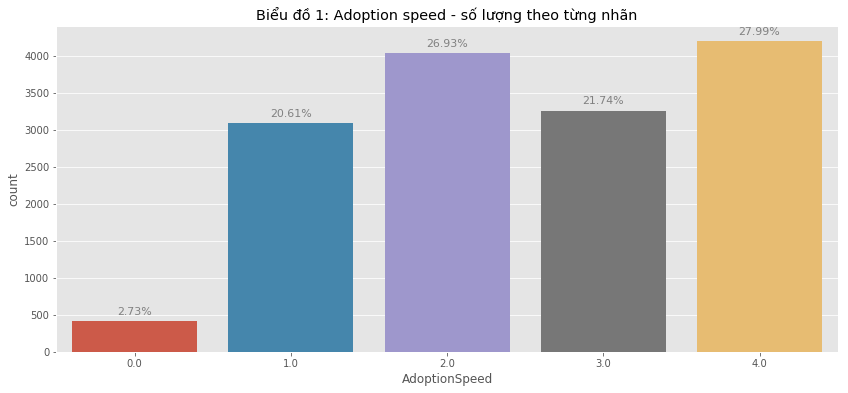

In [ ]:
plt.figure(figsize=(14, 6));
g = sns.countplot(x='AdoptionSpeed', data=all_data.loc[all_data['dataset_type'] == 'train'])
plt.title('Biểu đồ 1: Adoption speed - số lượng theo từng nhãn');
ax=g.axes
for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / train.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='gray', rotation=0, xytext=(0, 10),
         textcoords='offset points')  

**Kết quả:** Số lưỡng nhãn 0 là ít nhất, số lượng nhãn 4 là nhiều nhất, ngoại trừ nhãn 0 các nhãn còn lại có tỉ lệ không chênh lệch nhau nhiều

**Kết luận:** Cần tìm hiểu nguyên nhân 1 số lượng lớn vật nuôi vẫn không được nhận nuôi sau 100 ngày

### 1.4.2. Type
1 - Dog, 2 - Cat

In [ ]:
all_data['Type'] = all_data['Type'].apply(lambda x: 'Dog' if x == 1 else 'Cat')

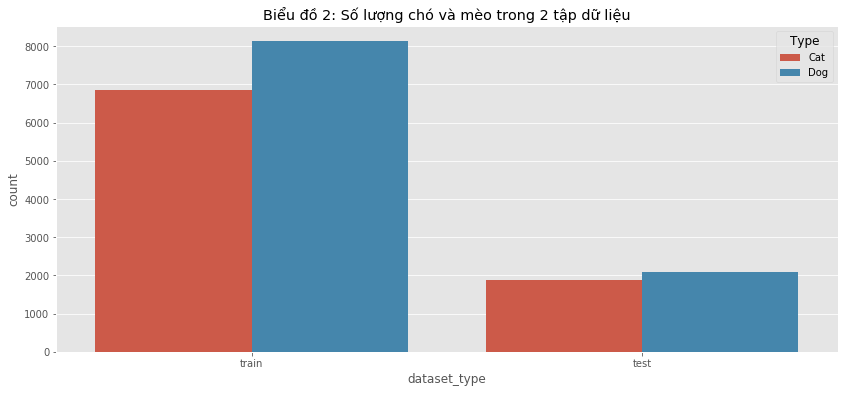

In [ ]:
plt.figure(figsize=(14, 6));
sns.countplot(x='dataset_type', data=all_data, hue='Type');
plt.title('Biểu đồ 2: Số lượng chó và mèo trong 2 tập dữ liệu');

In [ ]:
data=train.loc[train['Type'] == 2]

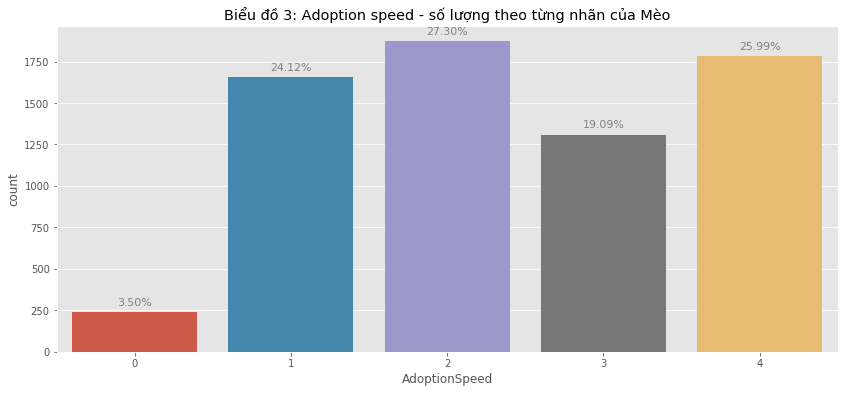

In [ ]:
plt.figure(figsize=(14, 6));
g = sns.countplot(x='AdoptionSpeed', data=train.loc[train['Type'] == 2])
plt.title('Biểu đồ 3: Adoption speed - số lượng theo từng nhãn của Mèo');
ax=g.axes
for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / data.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='gray', rotation=0, xytext=(0, 10),
         textcoords='offset points')

#### So sánh tỉ lệ nhận nuôi

**Vấn đề cần giải quyết:** So sánh tỷ lệ nhận nuôi giữa các yếu tố khác nhau giúp đưa ra vấn đề rằng tại sao thú nuôi lại được nhận nuôi sớm hoặc muộn

**Cách làm:**
Tỷ lệ nhận nuôi theo từng đặc điểm được so sánh % tăng giảm so với tỷ lệ trung bình (Biểu đồ 1)
* Tỷ lệ nhận nuôi trung bình với nhãn 0 là 2.73% (Biểu đồ 1)
* Tỷ lệ nhận nuôi mèo với nhãn 0 là 3.5% (Biểu đồ 3)
* 0.035/0.027 = 1.28, vậy chúng ta có tỉ lệ tăng 28% so với trung bình



In [ ]:
main_count = train['AdoptionSpeed'].value_counts(normalize=True).sort_index()
def prepare_plot_dict(df, col, main_count):
    """
    Tỉ lệ nhận nuôi dựa trên đặc điểm cần thể hiện với số phần trăm so sánh với tỉ lệ nhận nuôi trung bình (phía trên)

    """
    main_count = dict(main_count)
    plot_dict = {}
    for i in df[col].unique():
        val_count = dict(df.loc[df[col] == i, 'AdoptionSpeed'].value_counts().sort_index())

        for k, v in main_count.items():
            if k in val_count:
                plot_dict[val_count[k]] = ((val_count[k] / sum(val_count.values())) / main_count[k]) * 100 - 100
            else:
                plot_dict[0] = 0

    return plot_dict

def make_count_plot(df, x, hue='AdoptionSpeed', title='', main_count=main_count):
    
    g = sns.countplot(x=x, data=df, hue=hue);
    plt.title(title);
    ax = g.axes
    """
    Chuẩn bị dữ liệu để tạo biểu đồ
    """
    plot_dict = prepare_plot_dict(df, x, main_count)
    
    """
    Tạo biểu đồ
    """
    for p in ax.patches:
        h = p.get_height() if str(p.get_height()) != 'nan' else 0
        text = f"{plot_dict[h]:.0f}%" if plot_dict[h] < 0 else f"+{plot_dict[h]:.0f}%"
        """
        Màu xanh cho tỉ lệ lớn hơn trung bình và màu đỏ cho tỉ lệ dưới trung bình
        """
        ax.annotate(text, (p.get_x() + p.get_width() / 2., h),
             ha='center', va='center', fontsize=11, color='green' if plot_dict[h] > 0 else 'red', rotation=0, xytext=(0, 10),
             textcoords='offset points')  

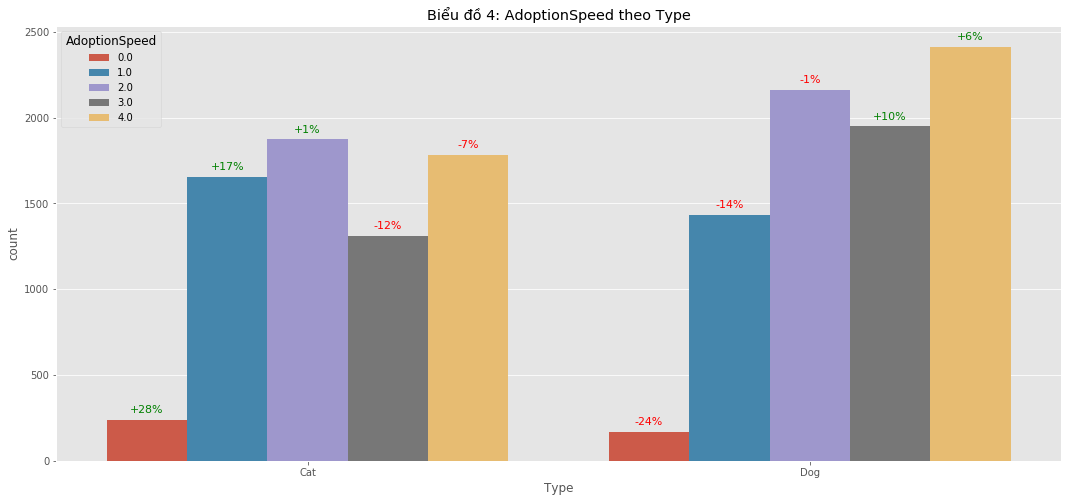

In [ ]:
plt.figure(figsize=(18, 8));
make_count_plot(df=all_data.loc[all_data['dataset_type'] == 'train'], x='Type', title='Biểu đồ 4: AdoptionSpeed theo Type')

**Kết quả:** Theo biểu đồ 4 có thể nhận ra được rằng Mèo có xu hướng được nhận nuôi sớm hơn chó, số lượng không được nhận nuôi (Nhãn 4) cũng thấp hơn.

### 1.4.3. Name

In [ ]:
print('Những cái tên phổ biến theo AdoptionSpeed')
for n in train['Name'].value_counts().index[:5]:
    print(n)
    print(train.loc[train['Name'] == n, 'AdoptionSpeed'].value_counts().sort_index())
    print('')

Những cái tên phổ biến theo AdoptionSpeed
Baby
0     2
1    11
2    15
3    11
4    27
Name: AdoptionSpeed, dtype: int64

Lucky
0     5
1    14
2    16
3    12
4    17
Name: AdoptionSpeed, dtype: int64

Brownie
0     1
1    11
2    14
3    12
4    16
Name: AdoptionSpeed, dtype: int64

No Name
0     3
1    14
2    11
3     6
4    20
Name: AdoptionSpeed, dtype: int64

Mimi
0     3
1    12
2    13
3     7
4    17
Name: AdoptionSpeed, dtype: int64



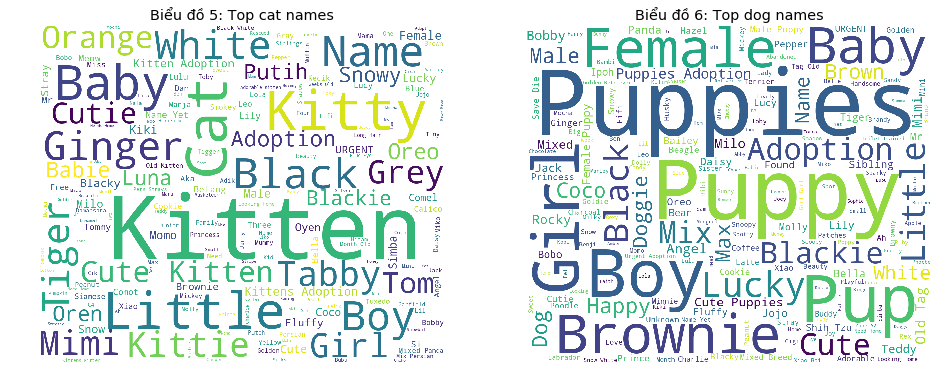

In [ ]:
fig, ax = plt.subplots(figsize = (16, 12))
plt.subplot(1, 2, 1)
text_cat = ' '.join(all_data.loc[all_data['Type'] == 'Cat', 'Name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_cat)
plt.imshow(wordcloud)
plt.title('Biểu đồ 5: Top cat names')
plt.axis("off")

plt.subplot(1, 2, 2)
text_dog = ' '.join(all_data.loc[all_data['Type'] == 'Dog', 'Name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_dog)
plt.imshow(wordcloud)
plt.title('Biểu đồ 6: Top dog names')
plt.axis("off")

plt.show()

**Nhận xét:** 
* Những cái tên phổ biến như Kitty, Puppy,... được dùng nhiều
* Màu sắc và các đặc điểm khác của vật nuôi cũng được sử dụng làm tên và khá phổ biến
* Một số vật nuôi không có tên

#### a. No name

**Vấn đề cần giải quyết:** Cần điền các giá trị thiếu cho trường Name

**Cách làm:** Điền cho các giá trị null trong Name thành Unnamed

**Kết quả:** Tỉ lệ thú nuôi không có tên trong các tập dữ liệu

In [ ]:
train['Name'] = train['Name'].fillna('Unnamed')
test['Name'] = test['Name'].fillna('Unnamed')
all_data['Name'] = all_data['Name'].fillna('Unnamed')

train['No_name'] = 0
train.loc[train['Name'] == 'Unnamed', 'No_name'] = 1
test['No_name'] = 0
test.loc[test['Name'] == 'Unnamed', 'No_name'] = 1
all_data['No_name'] = 0
all_data.loc[all_data['Name'] == 'Unnamed', 'No_name'] = 1

print(f"Rate of unnamed pets in train data: {train['No_name'].sum() * 100 / train['No_name'].shape[0]:.4f}%.")
print(f"Rate of unnamed pets in test data: {test['No_name'].sum() * 100 / test['No_name'].shape[0]:.4f}%.")

Rate of unnamed pets in train data: 8.4173%.
Rate of unnamed pets in test data: 10.3474%.


**So sánh tỉ lệ nhận nuôi giữa động vật có tên/ không có tên với tỉ lệ nhận nuôi trung bình**

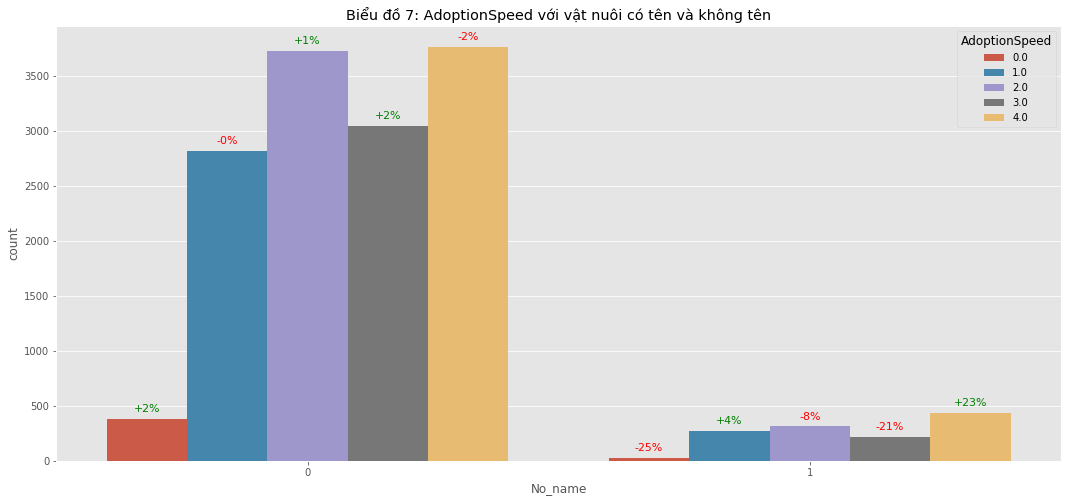

In [ ]:
plt.figure(figsize=(18, 8));
make_count_plot(df=all_data.loc[all_data['dataset_type'] == 'train'], x='No_name', title='Biểu đồ 7: AdoptionSpeed với vật nuôi có tên và không tên')

**Kết luận:** Một số lượng lớn vật nuôi không có tên (khoảng 10%) và tỉ lệ được nhận nuôi của các vật nuôi này cũng thấp hơn nhiều so với trung bình

#### b. "Bad" names

**Những cái tên có 1-2 ký tự**

In [ ]:
all_data[all_data['Name'].apply(lambda x: len(str(x))) < 3]['Name'].unique()

array(['H3', 'Z3', 'C', 'BB', 'QQ', 'Y1', 'H1', 'D9', 'Y4', 'Z4', 'DD',
       'M2', 'H6', 'D4', 'JJ', 'F1', 'W7', '1F', 'Q1', '6', 'CJ', '3F',
       'KD', 'G1', 'B3', 'Cc', 'F6', 'Mk', 'A5', 'GM', 'D5', 'EE', 'A4',
       'Q4', 'B', 'CC', 'Y7', 'W6', 'A3', 'A1', 'T1', 'W1', 'M4', 'P5',
       'H2', 'GG', 'Y6', 'Z', 'D7', 'B4', 'C2', 'M8', '3', 'G2', 'ML',
       'DJ', 'PP', '8', 'OJ', 'D', 'F2', 'MJ', 'W8', 'W4', 'C1', 'W2',
       'GR', 'B1', '5', 'Fa', 'Y5', 'M', 'F5', 'Y0', 'B2', 'Q6', 'G3',
       '..', 'S1', 'Qu', 'R9', 'W3', 'R7', 'Tj', 'P3', '7', '!', 'RC',
       'Z2', 'Q3', 'A2', 'QD', 'S', '-', 'R6', 'IV', 'Mo', 'W5', 'F8',
       'M6', 'M9', 'Py', 'Rt', 'F9', 'P6', 'AJ', 'Y3', 'D6', 'T2', 'F4',
       'T3', 'YY', '99', 'F7', 'W+', 'D2', '1', '#1', 'S4', '2', 'Am',
       'P', 'P4', 'R5', 'M3', 'R3', 'JD', 'BJ', 'L', 'KC', 'VV', 'M1',
       '!.', 'V6', 'P1', 'J', 'S3', 'A6', 'Cq', 'M5', 'B5', 'J1', 'O',
       '2F', 'Q2', 'Y2', 'AB', 'A', 'Jo', 'ET', 'A9', 'ST', 'Po', 'KK'

**Vấn đề cần giải quyết:** Những cái tên đặc biệt này không có ý nghĩa gì, mỗi tên chỉ có 1 con duy nhất, ta có thể cho chúng 1 cái tên chung để mô hình học một cách hiệu quả hơn

### 1.4.4. Age

In [ ]:
train['Age'].value_counts().head(10)

2     3503
1     2304
3     1966
4     1109
12     967
24     651
5      595
6      558
36     417
8      309
Name: Age, dtype: int64

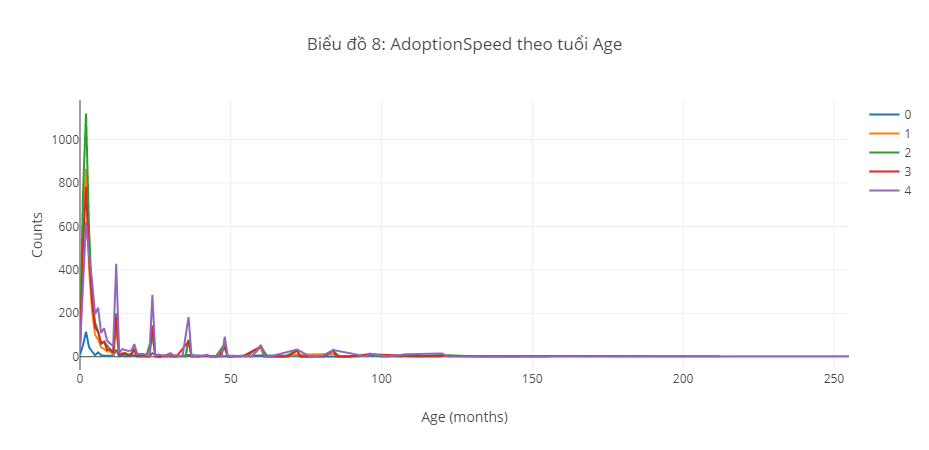

In [ ]:
data = []
for a in range(5):
    df = train.loc[train['AdoptionSpeed'] == a]

    data.append(go.Scatter(
        x = df['Age'].value_counts().sort_index().index,
        y = df['Age'].value_counts().sort_index().values,
        name = str(a)
    ))
    
layout = go.Layout(dict(title = "Biểu đồ 8: AdoptionSpeed theo tuổi Age",
                  xaxis = dict(title = 'Age (months)'),
                  yaxis = dict(title = 'Counts'),
                  )
                  )
py.iplot(dict(data=data, layout=layout), filename='basic-line')

**Nhận xét:** Các vật nuôi trong dữ liệu có tuổi rất nhỏ chiếm số lượng lớn, có thể là vừa sinh ra. Tuy vậy trong top 10 lại xuất hiện những tuổi lớn và là bội số của 12, có thể nhận định số liệu khi nhận nuôi không còn chính xác theo từng tháng mà theo từng năm.

### 1.4.5. Breeds
Mỗi vật nuôi có giống chính và giống phụ

**Vấn đề cần giải quyết:** thử xem giống phụ có ảnh hưởng nhiều đến quá trình phân loại hay không

**Cách giải quyết:** Nếu vật nuôi chỉ có giống chính đánh dấu chúng là giống thuần chủng (Pure_breed)

In [ ]:
train['Pure_breed'] = 0
train.loc[train['Breed2'] == 0, 'Pure_breed'] = 1
test['Pure_breed'] = 0
test.loc[test['Breed2'] == 0, 'Pure_breed'] = 1
all_data['Pure_breed'] = 0
all_data.loc[all_data['Breed2'] == 0, 'Pure_breed'] = 1

print(f"Rate of pure breed pets in train data: {train['Pure_breed'].sum() * 100 / train['Pure_breed'].shape[0]:.4f}%.")
print(f"Rate of pure breed pets in test data: {test['Pure_breed'].sum() * 100 / test['Pure_breed'].shape[0]:.4f}%.")

Rate of pure breed pets in train data: 71.7802%.
Rate of pure breed pets in test data: 74.6979%.


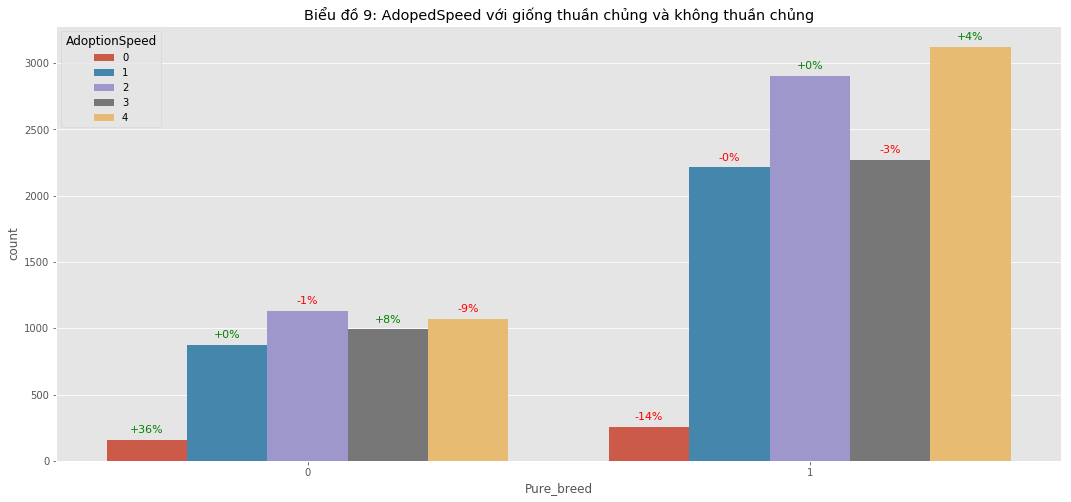

In [ ]:
plt.figure(figsize=(18, 8));
make_count_plot(df=train, x='Pure_breed', title='Biểu đồ 9: AdopedSpeed với giống thuần chủng và không thuần chủng')


**Nhận xét:** Từ biểu đồ 9 ta thấy được rằng giống thuần chủng có xu hướng được nhận nuôi chậm hơn so với giống không thuần chủng

In [ ]:
breeds_dict = {k: v for k, v in zip(breeds['BreedID'], breeds['BreedName'])}

In [ ]:
train['Breed1_name'] = train['Breed1'].apply(lambda x: '_'.join(breeds_dict[x].split()) if x in breeds_dict else 'Unknown')
train['Breed2_name'] = train['Breed2'].apply(lambda x: '_'.join(breeds_dict[x]) if x in breeds_dict else '-')

test['Breed1_name'] = test['Breed1'].apply(lambda x: '_'.join(breeds_dict[x].split()) if x in breeds_dict else 'Unknown')
test['Breed2_name'] = test['Breed2'].apply(lambda x: '_'.join(breeds_dict[x].split()) if x in breeds_dict else '-')

all_data['Breed1_name'] = all_data['Breed1'].apply(lambda x: '_'.join(breeds_dict[x].split()) if x in breeds_dict else 'Unknown')
all_data['Breed2_name'] = all_data['Breed2'].apply(lambda x: '_'.join(breeds_dict[x].split()) if x in breeds_dict else '-')

In [ ]:
(all_data['Breed1_name'] + '__' + all_data['Breed2_name']).value_counts().head(15)

Mixed_Breed__-                                5724
Domestic_Short_Hair__-                        3945
Domestic_Medium_Hair__-                       1255
Mixed_Breed__Mixed_Breed                      1213
Domestic_Short_Hair__Domestic_Short_Hair       330
Tabby__-                                       294
Domestic_Long_Hair__-                          220
Shih_Tzu__-                                    203
Poodle__-                                      162
Siamese__-                                     147
Labrador_Retriever__Mixed_Breed                146
Golden_Retriever__-                            119
Domestic_Medium_Hair__Domestic_Medium_Hair     119
Domestic_Medium_Hair__Domestic_Short_Hair      114
Persian__-                                     108
dtype: int64

**Nhận xét:** Mặc dù đã phân chia thành nhiều loại giống nhưng vẫn có loại giống được đặt tên là 'Mixed_Breed', việc giống thuần chủng hay không đã không còn đúng nữa

### 1.4.6. Gender
 1 = Male, 2 = Female, 3 = Mixed

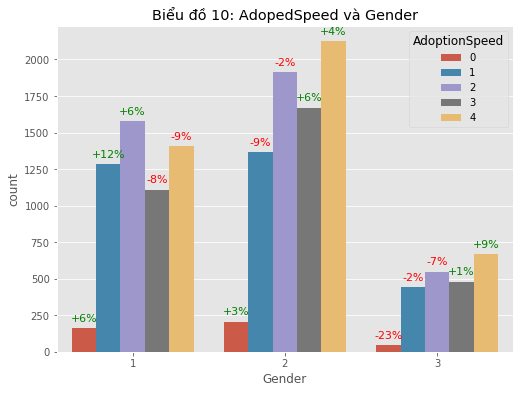

In [ ]:
plt.figure(figsize=(18, 6));
plt.subplot(1, 2, 1)
make_count_plot(df=train, x='Gender', title='Biểu đồ 10: AdopedSpeed và Gender')

**Nhận xét:** Con đực có xu hướng được nhận nuôi sớm hơn con cái

### 1.4.7. Colors

Nối ID và tên màu của vật nuôi để dễ biểu diễn

In [ ]:
colors_dict = {k: v for k, v in zip(colors['ColorID'], colors['ColorName'])}
train['Color1_name'] = train['Color1'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
train['Color2_name'] = train['Color2'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
train['Color3_name'] = train['Color3'].apply(lambda x: colors_dict[x] if x in colors_dict else '')

test['Color1_name'] = test['Color1'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
test['Color2_name'] = test['Color2'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
test['Color3_name'] = test['Color3'].apply(lambda x: colors_dict[x] if x in colors_dict else '')

all_data['Color1_name'] = all_data['Color1'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
all_data['Color2_name'] = all_data['Color2'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
all_data['Color3_name'] = all_data['Color3'].apply(lambda x: colors_dict[x] if x in colors_dict else '')

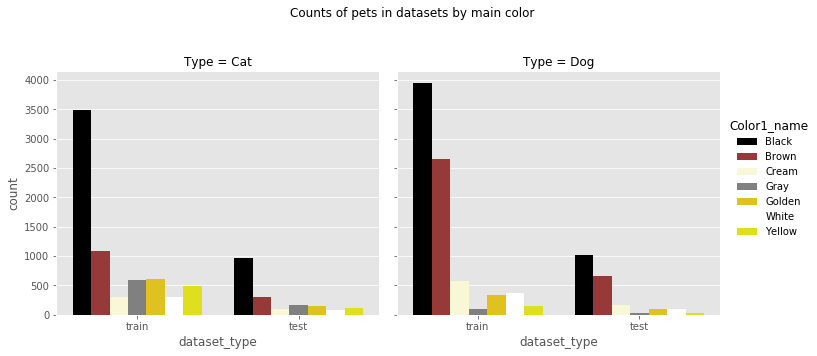

In [ ]:
sns.factorplot('dataset_type', col='Type', data=all_data, kind='count', hue='Color1_name', palette=['Black', 'Brown', '#FFFDD0', 'Gray', 'Gold', 'White', 'Yellow']);
plt.subplots_adjust(top=0.8)
plt.suptitle('Counts of pets in datasets by main color');

**Nhận xét:** Các vật nuôi có 1 lượng lớn là màu đen hoặc nâu

- Nối tất cả các màu lại thành 1 trường là 'full_color'

In [ ]:
train['full_color'] = (train['Color1_name'] + '__' + train['Color2_name'] + '__' + train['Color3_name']).str.replace('__', '')
test['full_color'] = (test['Color1_name'] + '__' + test['Color2_name'] + '__' + test['Color3_name']).str.replace('__', '')
all_data['full_color'] = (all_data['Color1_name'] + '__' + all_data['Color2_name'] + '__' + all_data['Color3_name']).str.replace('__', '')

In [ ]:
top_colors = list(all_data['full_color'].value_counts().index)[:5]
print(f"Top 5 màu lông: {' '.join(top_colors)}")

Top 5 màu lông: Brown BlackWhite BlackBrown BlackBrownWhite Black


### 1.4.8. MatiritySize
Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)

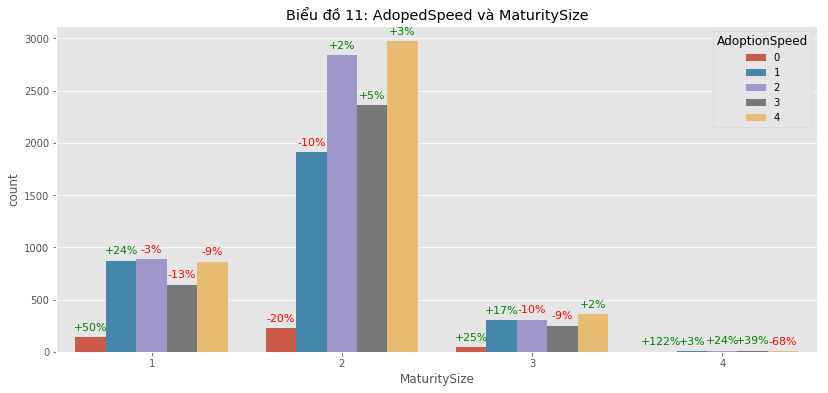

In [ ]:
plt.figure(figsize=(30, 6));
plt.subplot(1, 2, 1)
make_count_plot(df=train, x='MaturitySize', title='Biểu đồ 11: AdopedSpeed và MaturitySize')

**Nhận xét:** 
- Vật nuôi có kích thước cực đại và nhỏ có xu hướng nhận nuôi rất nhanh
- Kích thước vật nuôi không quá quan trọng trong việc phân loại

### 1.4.9. FurLength

 (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)

* We can see that most of the pets have short fur and long fur is the least common;
* Pets with long hair tend to have a higher chance of being adopted. Though it could be because of randomness due to low count;

As I said earlier, some breed have hair length in the text, let's check these values!

In [ ]:
c = 0
strange_pets = []
for i, row in all_data[all_data['Breed1_name'].str.contains('air')].iterrows():
    if 'Short' in row['Breed1_name'] and row['FurLength'] == 1:
        pass
    elif 'Medium' in row['Breed1_name'] and row['FurLength'] == 2:
        pass
    elif 'Long' in row['Breed1_name'] and row['FurLength'] == 3:
        pass
    else:
        c += 1
        strange_pets.append((row['PetID'], row['Breed1_name'], row['FurLength']))
        
print(f"Có {c} vật nuôi có giống và độ dài lông không giống nhau")

Có 921 vật nuôi có giống và độ dài lông không giống nhau


- Xem qua hình ảnh về các vật nuôi này

In [ ]:
images = [i.split('-')[0] for i in os.listdir('../input/train_images/')]

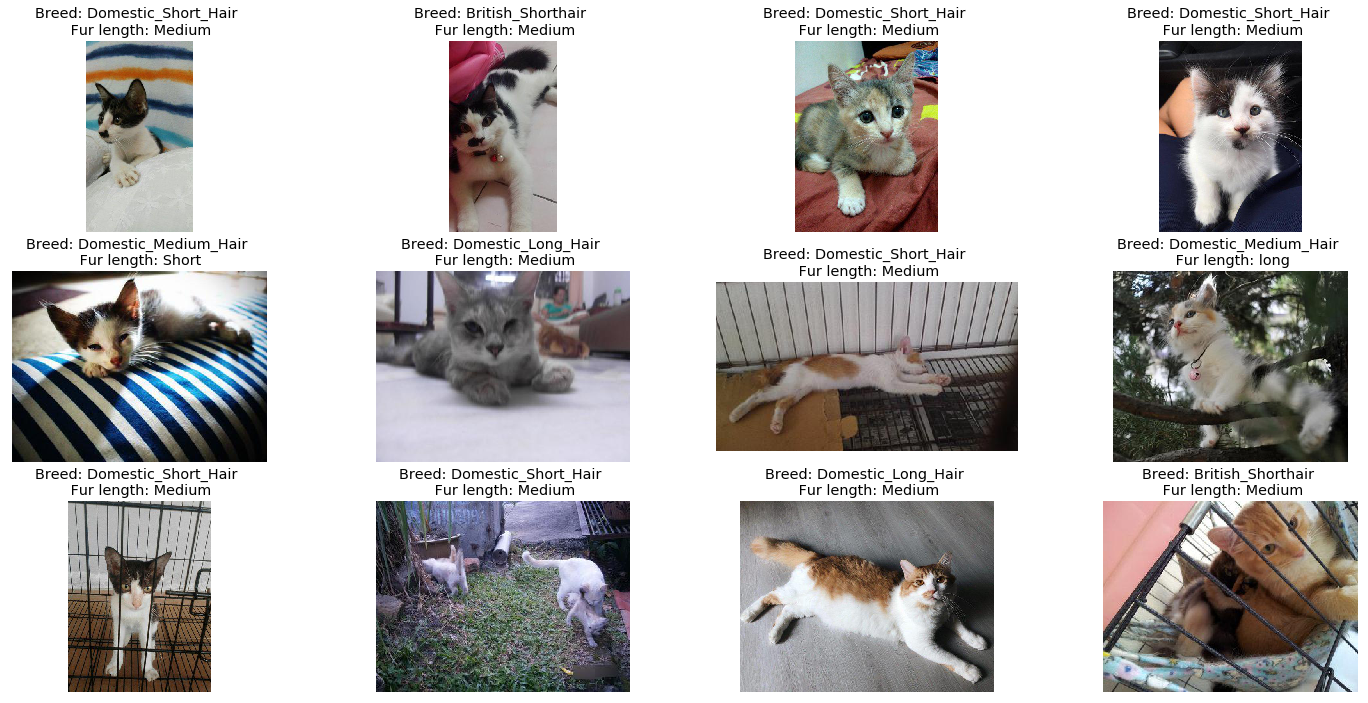

In [ ]:
strange_pets = [p for p in strange_pets if p[0] in images]
fig = plt.figure(figsize=(25, 12))
fur_dict = {1: 'Short', 2: 'Medium', 3: 'long'}
for i, s in enumerate(random.sample(strange_pets, 12)):
    ax = fig.add_subplot(3, 4, i+1, xticks=[], yticks=[])

    im = Image.open("../input/train_images/" + s[0] + '-1.jpg')
    plt.imshow(im)
    ax.set_title(f'Breed: {s[1]} \n Fur length: {fur_dict[s[2]]}')
plt.show();

**Nhận xét:** Có lúc thì giống đúng thực tế có lúc độ dài lông đúng thực tế

### 1.4.10. Health
* Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
* Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)

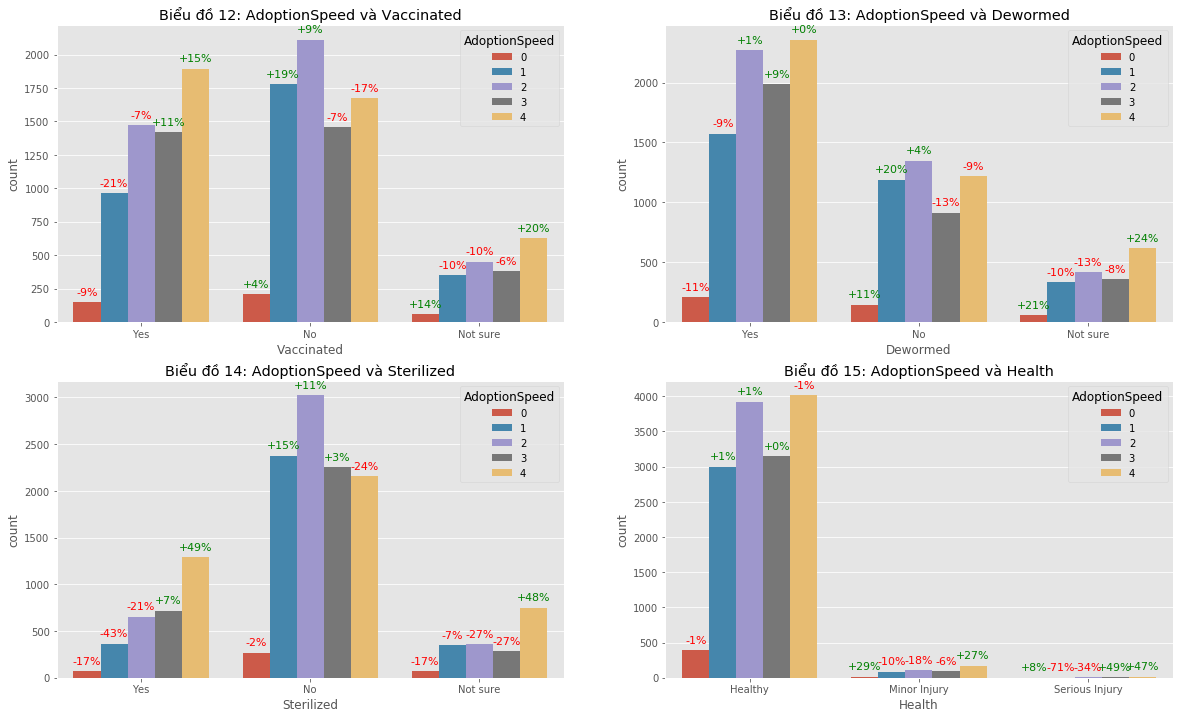

In [ ]:
plt.figure(figsize=(20, 12));
plt.subplot(2, 2, 1)
make_count_plot(df=train, x='Vaccinated', title='Vaccinated')
plt.xticks([0, 1, 2], ['Yes', 'No', 'Not sure']);
plt.title('Biểu đồ 12: AdoptionSpeed và Vaccinated');

plt.subplot(2, 2, 2)
make_count_plot(df=train, x='Dewormed', title='Dewormed')
plt.xticks([0, 1, 2], ['Yes', 'No', 'Not sure']);
plt.title('Biểu đồ 13: AdoptionSpeed và Dewormed');

plt.subplot(2, 2, 3)
make_count_plot(df=train, x='Sterilized', title='Sterilized')
plt.xticks([0, 1, 2], ['Yes', 'No', 'Not sure']);
plt.title('Biểu đồ 14: AdoptionSpeed và Sterilized');

plt.subplot(2, 2, 4)
make_count_plot(df=train, x='Health', title='Health')
plt.xticks([0, 1, 2], ['Healthy', 'Minor Injury', 'Serious Injury']);
plt.title('Biểu đồ 15: AdoptionSpeed và Health');

In [ ]:
train['health'] = train['Vaccinated'].astype(str) + '_' + train['Dewormed'].astype(str) + '_' + train['Sterilized'].astype(str) + '_' + train['Health'].astype(str)
test['health'] = test['Vaccinated'].astype(str) + '_' + test['Dewormed'].astype(str) + '_' + test['Sterilized'].astype(str) + '_' + test['Health'].astype(str)

**Nhận xét:**
- Số lượng vật nuôi được tiêm phòng và tẩy giun lớn
- Số lượng vật nuôi không chắc về tình trạng sức khỏe có khả năng không được nhận nuôi cao hơn hẳn

### 1.4.11. Quantity

- Trong cùng 1 trường thông tin có thể đại diện cho nhiều vật nuôi khác nhau

In [ ]:
train.loc[train['Quantity'] > 11][['Name', 'Description', 'Quantity', 'AdoptionSpeed']].head(5)

,Name,Description,Quantity,AdoptionSpeed
263,20 Little Puppies,"These are 20 puppies, from 2 stray mums need good homes. They are 2 weeks old. If you can give them a good home without caging or chaining, please whatsapp or msg Ms Grace Bong tel no:",20,4
320,18 Cats For NEED HOMES!!,"YOU can CONTACT the couple at if you are interested. MORE pictures available here: THE HISTORY: They were basically abandoned by their previous owner who left them behind when he moved out. The couple that moved in was left to look after them and has slowly been finding homes for the cats over the last year. There were 28 to begin with and there are 18 left. The last 18 NEED HOMES URGENTLY as the couple is no longer able to care for them. Due to some personal issues, and a new baby then need...",18,4
396,"Giant, Cookie & Snoopy. ! Thanks!","puppies for adoption. Rescued by some good samaritans. No information on breeds, probably mongrels. All about a month old. They have been dewormed but not yet vaccinated. Cookie- female- Smaller than the rest but fiesty! Snoopy- male- Attention seeker. LOVES wagging his tail! Giant- male- Gentle giant. Very soft fur coat! Very playful! Some videos: Giant and his tennis ball- Giant playing with Snoopy- Giant being bullied- ----------------------------------------------------------------------...",12,2
427,OMIEY'S HOME,"Hi, kepada sesiapa yang berminat untuk adopt kucing-kucing sila hubungi saya . Di sini ada berbagai jenis kucing, dari short hair - long hair.",20,4
823,Pancho & Tita,"Pancho and Tita are 2 adorable, playful kittens. They can be shy at first but once they get to know you they are the sweetest pets anyone could ask for. Available for adoption now. They are very, very close so we are looking for someone who can take them both.",12,2


### 1.4.12. Fee

In [ ]:
all_data.sort_values('Fee', ascending=False)[['Name', 'Description', 'Fee', 'AdoptionSpeed', 'dataset_type']].head(5)

,Name,Description,Fee,AdoptionSpeed,dataset_type
8722,Khaleesi And Drogo,"Both pups are family home trained. They love their walks on lead and off lead. Both male and female are from different lineage and both have MKA Reg Certs. They are 4mths and at perfect age for training. The 2pups know some commands like ""sit"" ""outside"" ""leave"" ""crate"" and more. They are family friendly and can stay/sleep indoors and out. They've just learnt to swim and belly rubs. Great dogs for families that wants a pet and a watchdog too. All vaccines complete, dewormed, microchipped and ...",3000,3.0,train
10477,Bull Dog,"Found this bull dog near my neighbourhood for a month now. I have 3 dogs myself at home. Cannot take care of it. Hopefully if there is someone who is loving who can take care of it. It is very cute and friendly but the saliva keep on drooling. overall there is nothing. forgot to mention, please keep him indoor. He likes to sleep on mattress or sofa, if can please prepare a mattress for him. PLEASE SMS , DONT CALL",2000,1.0,train
207,Unnamed,These two german shepherds are looking for a home together as their owner has passed away. One is 4 yrs old the second is 2.5-3 yrs old. The 4 yr old has a deformed back leg and recently had her tail amputated but she is able to continue walking. Good temperament. Dogs will be spayed before passing to adopter. Adoption fee will be used to cover spaying costs.,1500,NaN,test
2078,Rottweiler - Adoption,Open for Adoption with Fees Looking for new lovely home due to owner lack of time & care... Vaccination & Deworm up to date Contact me for more details,1000,2.0,train
3469,Cheras,We have just rescued a dog at 18.5km grand saga highway from Cheras heading to Kajang. We believe it is a stray and he is now undergoing a surgery at everise veterinarian clinic at Kajang Prima. According to the doctor his vertebrate t-12 and t-13 has broken and suffered from a fracture of his left tibia and fibula. The brave dog will recuperate for around one week before he can be adopted. We are currently urgently looking for people who has compassion towards injured (and may even be paral...,1000,NaN,test


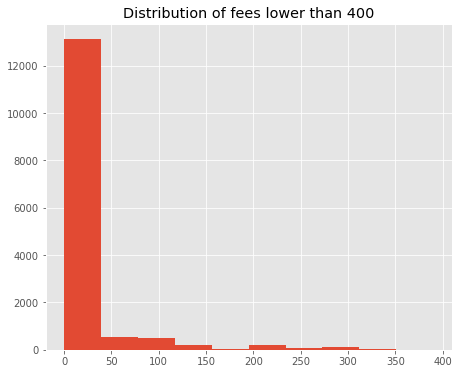

In [ ]:
plt.figure(figsize=(16, 6));
plt.subplot(1, 2, 1)
plt.hist(train.loc[train['Fee'] < 400, 'Fee']);
plt.title('Distribution of fees lower than 400');

**Nhận xét:**
- Đa phần vật nuôi được miễn phí

In [ ]:
train['Free'] = train['Fee'].apply(lambda x: 1 if x == 0 else 0)
test['Free'] = test['Fee'].apply(lambda x: 1 if x == 0 else 0)
all_data['Free'] = all_data['Fee'].apply(lambda x: 1 if x == 0 else 0)

### 1.4.13. State

- Nối ID và tên State với nhau

In [ ]:
states_dict = {k: v for k, v in zip(states['StateID'], states['StateName'])}
train['State_name'] = train['State'].apply(lambda x: '_'.join(states_dict[x].split()) if x in states_dict else 'Unknown')
test['State_name'] = test['State'].apply(lambda x: '_'.join(states_dict[x].split()) if x in states_dict else 'Unknown')
all_data['State_name'] = all_data['State'].apply(lambda x: '_'.join(states_dict[x].split()) if x in states_dict else 'Unknown')

In [ ]:
all_data['State_name'].value_counts(normalize=True)

Selangor           0.556130
Kuala_Lumpur       0.259267
Pulau_Pinang       0.071342
Johor              0.033430
Perak              0.029897
Negeri_Sembilan    0.018666
Melaka             0.011073
Kedah              0.009122
Pahang             0.005378
Sabah              0.001529
Terengganu         0.001529
Kelantan           0.001160
Sarawak            0.000949
Labuan             0.000369
Perlis             0.000158
Name: State_name, dtype: float64

**Nhận xét:** Đa phân vật nuôi đến từ Selangor và Kuala_Lumpur

### 1.4.14. Rescuer

Top 5 người cứu hộ cứu được nhiều thú nuôi nhất

In [ ]:
all_data['RescuerID'].value_counts().head()

fa90fa5b1ee11c86938398b60abc32cb    459
aa66486163b6cbc25ea62a34b11c9b91    315
c00756f2bdd8fa88fc9f07a8309f7d5d    231
b53c34474d9e24574bcec6a3d3306a0d    228
62a25cadb85658be5275bd54a3b8c76d    162
Name: RescuerID, dtype: int64

### 1.4.15. VideoAmt

In [ ]:
train['VideoAmt'].value_counts()

0    14419
1      417
2       92
3       36
4       15
5        7
6        4
8        2
7        1
Name: VideoAmt, dtype: int64

**Nhận xét:** Đa phần thông tin vật nuôi không có video, feature này không quan trọng trong việc phân loại

### 1.4.16. PhotoAmt

In [ ]:
print(F'Số lượng ảnh được đăng tải trên mỗi trường thông tin')
train['PhotoAmt'].value_counts()

Số lượng ảnh được đăng tải trên mỗi trường thông tin


1.0     3075
2.0     2518
3.0     2511
5.0     2147
4.0     1881
6.0      621
7.0      432
0.0      341
8.0      314
9.0      231
10.0     190
11.0     184
12.0      97
13.0      86
14.0      78
15.0      50
16.0      39
17.0      27
20.0      25
19.0      20
30.0      19
18.0      18
21.0      16
24.0      15
23.0      12
26.0      10
22.0       9
25.0       8
28.0       7
27.0       6
29.0       6
Name: PhotoAmt, dtype: int64

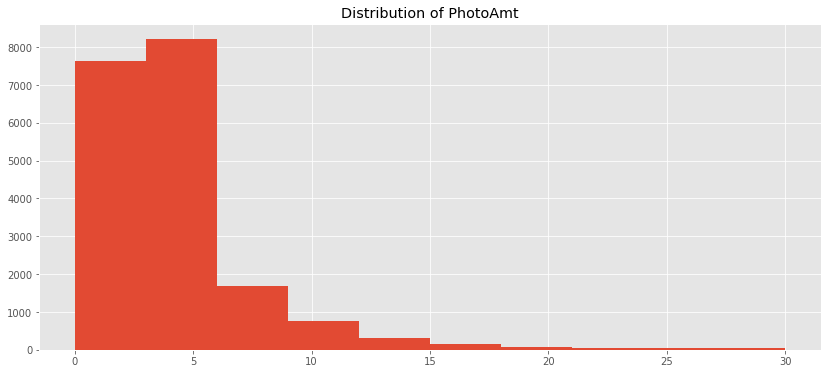

In [ ]:
plt.figure(figsize=(14, 6))
plt.hist(all_data['PhotoAmt'])
plt.title('Distribution of PhotoAmt')
plt.show()

**Nhận xét:** Số lượng ảnh được cập nhật rất nhiều

### 1.4.17. Description


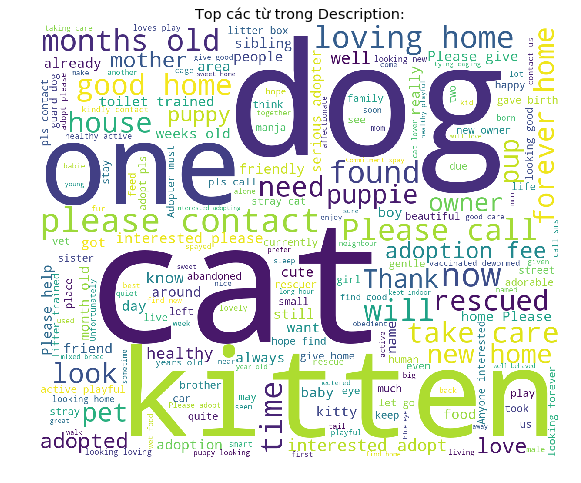

In [ ]:
fig, ax = plt.subplots(figsize = (12, 8))
text_cat = ' '.join(all_data['Description'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_cat)
plt.imshow(wordcloud)
plt.title('Top các từ trong Description:');
plt.axis("off");

In [ ]:
train['Description'] = train['Description'].fillna('')
test['Description'] = test['Description'].fillna('')
all_data['Description'] = all_data['Description'].fillna('')

train['desc_length'] = train['Description'].apply(lambda x: len(x))
train['desc_words'] = train['Description'].apply(lambda x: len(x.split()))

test['desc_length'] = test['Description'].apply(lambda x: len(x))
test['desc_words'] = test['Description'].apply(lambda x: len(x.split()))

all_data['desc_length'] = all_data['Description'].apply(lambda x: len(x))
all_data['desc_words'] = all_data['Description'].apply(lambda x: len(x.split()))

train['averate_word_length'] = train['desc_length'] / train['desc_words']
test['averate_word_length'] = test['desc_length'] / test['desc_words']
all_data['averate_word_length'] = all_data['desc_length'] / all_data['desc_words']

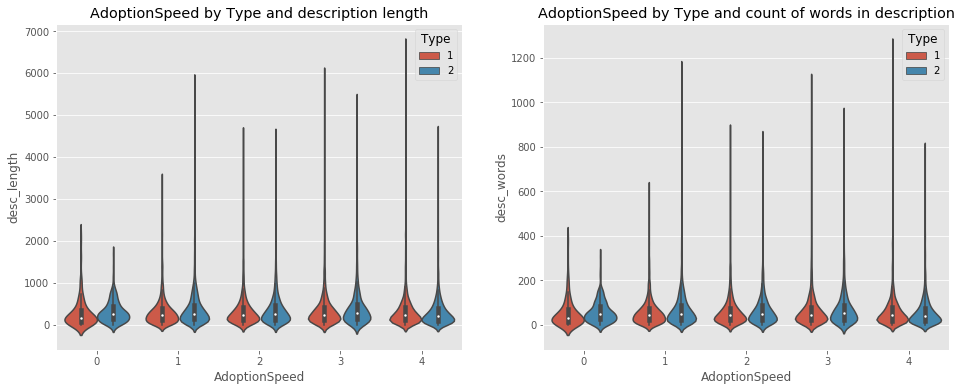

In [ ]:
plt.figure(figsize=(16, 6));
plt.subplot(1, 2, 1)
sns.violinplot(x="AdoptionSpeed", y="desc_length", hue="Type", data=train);
plt.title('AdoptionSpeed by Type and description length');

plt.subplot(1, 2, 2)
sns.violinplot(x="AdoptionSpeed", y="desc_words", hue="Type", data=train);
plt.title('AdoptionSpeed by Type and count of words in description');

## 1.5. Sentiment

In [ ]:
sentiment_dict = {}
for filename in os.listdir('../input/train_sentiment/'):
    with open('../input/train_sentiment/' + filename, 'r') as f:
        sentiment = json.load(f)
    pet_id = filename.split('.')[0]
    sentiment_dict[pet_id] = {}
    sentiment_dict[pet_id]['magnitude'] = sentiment['documentSentiment']['magnitude']
    sentiment_dict[pet_id]['score'] = sentiment['documentSentiment']['score']
    sentiment_dict[pet_id]['language'] = sentiment['language']

for filename in os.listdir('../input/test_sentiment/'):
    with open('../input/test_sentiment/' + filename, 'r') as f:
        sentiment = json.load(f)
    pet_id = filename.split('.')[0]
    sentiment_dict[pet_id] = {}
    sentiment_dict[pet_id]['magnitude'] = sentiment['documentSentiment']['magnitude']
    sentiment_dict[pet_id]['score'] = sentiment['documentSentiment']['score']
    sentiment_dict[pet_id]['language'] = sentiment['language']